### Objectives of this notebook:
- display output from ABRM
- perform analysis on output. eg. feature importance and model selection
- in console do: jupyter nbconvert --to="python" '.\Postprocessing.ipynb'
- this will upload the file in pure python format

In [1]:
import numpy as np
import pandas as pd
import plotly.io as pio
import ABRM_functions

pio.renderers.default = "notebook"

### Import data
- one df with FD performance of each particle  
- one df with associated particle position  
- one dicct with initial setup that would allow reproduction of results

In [2]:
dataset = ["2020_05_12_20_06"]
misfit_tolerance = 0.1

df_performance,df_position,setup_all, FD_targets = ABRM_functions.read_data(dataset)

print("Number of models and parameters:")
display(df_position.shape)
print("Number of particles:")
display(df_position.particle_no.max()+1)
print("Number of Iterations:")
display(df_position.iteration.max()+1)
display(df_performance.head())
display(df_position.head())

Number of models and parameters:


(270, 15)

Number of particles:


18

Number of Iterations:


15

EV        tD         F       Phi        LC  particle_no   misfit  \
0  0.000000  0.000000  0.000000  0.000000  0.173284            0  0.45157   
1  0.629716  0.629802  0.011478  0.007143  0.173284            0  0.45157   
2  0.636927  0.637138  0.022753  0.014286  0.173284            0  0.45157   
3  0.643752  0.644163  0.033903  0.021428  0.173284            0  0.45157   
4  0.649710  0.650363  0.044936  0.028571  0.173284            0  0.45157   

   iteration           dataset  
0          0  2020_05_12_20_06  
1          0  2020_05_12_20_06  
2          0  2020_05_12_20_06  
3          0  2020_05_12_20_06  
4          0  2020_05_12_20_06

P32  n_sides  elongation_ratio     shape      scale   mean_dip  \
0  1.359686      6.0          2.390126  2.588151  87.659742  45.270085   
1  0.949333      6.0          2.076433  4.250663  20.320282  22.612148   
2  1.483165      8.0          2.557590  3.079146  92.022924  89.059302   
3  1.205753      7.0          2.022809  3.252277  99.173900  14.175043   
4  1.207429      7.0          0.853801  2.993261  57.749603  53.371426   

   mean_dip_azimuth  concentration  aperture_mean  aperture_std    misfit  \
0         65.879804      20.622356       0.000656  2.515000e-07  0.451570   
1         10.170203      15.947136       0.000436  8.523700e-06  0.485819   
2         66.445346      42.507421       0.000320  2.802500e-06  0.490114   
3         76.654148       1.749461       0.000055  3.943200e-06  0.417761   
4          8.150845      52.180855       0.000553  1.118420e-05  0.405382   

   particle_no        LC  iteration           dataset  
0            0  0.173284          0  2020_05_12_20_06  
1            1  0.151339          0  2020_05_12_20_06  
2            2  0.148036          0  2020_05_12_20_06  
3            3  0.194775          0  2020_05_12_20_06  
4            4  0.203319          0  2020_05_12_20_06

### Plot performance

In [3]:
ABRM_functions.plot_performance(df_performance,df_position,FD_targets,setup_all,dataset,misfit_tolerance)

### Boxplots parameters
explore if ranges of parameters need potential modifications

In [4]:
ABRM_functions.plot_box(df = df_position,setup_all = setup_all, dataset = dataset)

### Histogram Paramters

In [5]:
ABRM_functions.plot_hist(df = df_position,setup_all = setup_all, dataset = dataset,misfit_tolerance = None)

### Histograms for best models parameters

In [6]:
ABRM_functions.plot_hist(df = df_position,setup_all = setup_all, dataset = dataset,misfit_tolerance = misfit_tolerance)

### Cluster best models with UMAP and HDBSCAN

In [10]:
df_best = ABRM_functions.best_model_selection_UMAP_HDBSCAN(df = df_position,dataset =dataset,setup_all = setup_all,
                                                           n_neighbors= 3, min_cluster_size=2, misfit_tolerance = misfit_tolerance,
                                                           use_UMAP = True)

### Build best performing models for flow simulation

In [11]:
best_models = ABRM_functions.save_best_clustered_models(df_best = df_best, datasets = dataset)

### Feature importance - model explainability

In [12]:
import shap
from sklearn.ensemble import RandomForestRegressor


In [13]:
columns = setup_all[dataset[0]]["columns"]
X_train = df_position[columns]
Y_train = df_position.LC

In [14]:
# load JS visualization code to notebook
shap.initjs()

In [15]:
model = RandomForestRegressor(max_depth=6, random_state=0, n_estimators=10)
model.fit(X_train, Y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


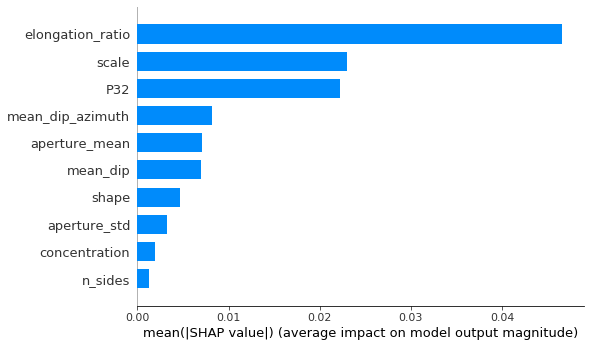

In [16]:
shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [17]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[80,:], X_train.iloc[80,:])

In [18]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values, X_train)

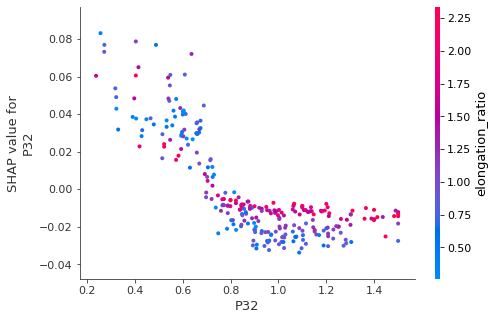

In [21]:
# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("P32", shap_values, X_train)

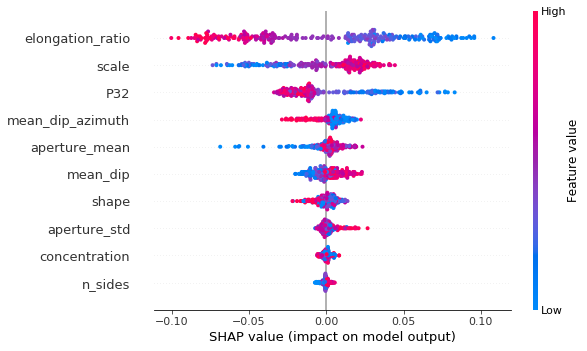

In [22]:
shap.summary_plot(shap_values, X_train)


In [ ]:
def plot_performance(df_performance,df_position,FD_targets,setup_all,dataset,misfit_tolerance):
    # Create traces

    fig = make_subplots(rows = 2, cols = 2,
                       subplot_titles = ("Misfit","LC plot","F - Phi Graph","Sweep Efficieny Graph"))

    ### Misfit ###
    
    fig.add_trace(go.Scatter(x = df_position.index[(df_position.dataset == dataset[0])], y=df_position.misfit[(df_position.dataset == dataset[0])],
                            mode='markers',
                            line = dict(color = "black"),
                            name='misfit'),row =1, col =1)
    
    fig.add_trace(go.Scatter( x= df_position.index[(df_position.misfit <= misfit_tolerance) & (df_position.dataset == dataset[0])],y=df_position.loc[(df_position.misfit <= misfit_tolerance) & (df_position.dataset == dataset[0]),"misfit"],
                            mode = "markers",
                            line = dict(color = "magenta")))

    fig.update_xaxes(range = [0,df_position.index.max()],row =1, col =1)
    fig.update_yaxes(range = [0,1], row =1, col = 1)

    ### LC plot ###
    
    fig.add_trace(go.Scatter(x = df_position.index, y=df_position.LC,
                            mode='markers',
                            line = dict(color = "lightgray"),
                            name='Simulated'),row =1, col =2)
    fig.add_trace(go.Scatter( x= df_position.index[(df_position.misfit <= misfit_tolerance)],y=df_position.loc[(df_position.misfit <= misfit_tolerance,"LC")],
                                mode = "markers",
                            line = dict(color = "magenta")),row =1, col =2)
    
    fig.add_shape(
            # Line Horizontal
                type="line",
                x0=0,
                y0=FD_targets[dataset[0]]["LC_interpolated"], # make date a criterion taht can be changed
                x1=df_position.index.max(),
                y1=FD_targets[dataset[0]]["LC_interpolated"],
                line=dict(
                    color="red",
                    width=2),row =1, col = 2)

    fig.update_xaxes(title_text = "particles",row = 1, col = 1)
    fig.update_yaxes(title_text = "RMSE",row = 1, col = 1)
    fig.update_xaxes(title_text = "particles",range = [0,df_position.index.max()],row =1, col = 2)
    fig.update_yaxes(title_text = "LC",range = [0,1], row =1, col = 2)

    ### F - Phi plot ###
    
    fig.add_trace(go.Scatter(x=df_performance.Phi, y=df_performance.F,
                            mode='lines',
                            line = dict(color = "lightgray"),
                            name='Simulated'),row =2, col =1)

    fig.add_trace(go.Scatter(x = df_performance.loc[(df_performance.misfit <= misfit_tolerance,"Phi")], # make misfit value a criterion that can be changed
                             y = df_performance.loc[(df_performance.misfit <= misfit_tolerance,"F")],
                            mode = "lines",
                            line = dict(color = "magenta"),
                            text = "nothing yet",
                            name = "best simulations"),row =2, col =1)
    
    fig.add_trace(go.Scatter(x = FD_targets[dataset[0]]["Phi_interpolated"], y = FD_targets[dataset[0]]["F_interpolated"],
                            mode = "lines",
                            line = dict(color = "red", width = 3),
                            name = "target"),row =2, col =1)
    
    fig.add_trace(go.Scatter(x = [0,1], y = [0,1],
                            mode = "lines",
                            line = dict(color = "black", width = 3),
                            name = "homogeneous"),row =2, col =1)

    fig.update_xaxes(title_text = "Phi", range = [0,1],row =2, col =1)
    fig.update_yaxes(title_text = "F",range = [0,1], row =2, col = 1)

    ### Sweep efficiency plot ###
    
    for i in range (0,df_performance.iteration.max()):
        iteration = i 
        for j in range(0,df_performance.particle_no.max()):
            particle_no = j
            EV = df_performance[(df_performance.iteration == iteration) & (df_performance.particle_no == particle_no)].EV
            tD = df_performance[(df_performance.iteration == iteration) & (df_performance.particle_no == particle_no)].tD

            fig.add_trace(go.Scatter(x=tD, y=EV,
                                mode='lines',
                                line = dict(color = "lightgray"),
                                text = "nothing yet",
                                name = "Simulated"),row =2, col =2)

    for i in range (0,df_performance.iteration.max()):
        iteration = i 
        for j in range(0,df_performance.particle_no.max()):
            particle_no = j
            EV = df_performance[(df_performance.iteration == iteration) & (df_performance.particle_no == particle_no) & (df_performance.misfit <= misfit_tolerance)].EV
            tD = df_performance[(df_performance.iteration == iteration) & (df_performance.particle_no == particle_no) & (df_performance.misfit <= misfit_tolerance)].tD

            fig.add_trace(go.Scatter(x=tD, y=EV,
                                mode='lines',
                                line = dict(color = "magenta"),
                                text = "nothing yet",
                                name = "best simulations"),row =2, col =2)

    fig.update_xaxes(title_text = "tD", range = [0,1],row =2, col =2)
    fig.update_yaxes(title_text = "Ev",range = [0,1], row =2, col = 2)

    fig.update_layout(title='Performance Evaluation - Simulation run {}'.format(dataset),
                       autosize = False,
                     width = 1000,
                     height = 1000,
                     showlegend = False)

    fig.show()


In [ ]:
def best_model_selection_UMAP_HDBSCAN(df,setup_all,dataset,n_neighbors,min_cluster_size,misfit_tolerance,use_UMAP = True):
    # at some point make n_eighbours and min cluster size nad misfit tolernaze sliding scales
    # model parameters that generate lowest misfit
    if use_UMAP == True:
        columns = setup_all[dataset[0]]["columns"]
        df_best =df[(df.misfit <= misfit_tolerance)].copy()
        df_best_for_clustering = df_best[columns].copy()
        
        # Create UMAP reducer
        reducer    = umap.UMAP(n_neighbors=n_neighbors)
        embeddings = reducer.fit_transform(df_best_for_clustering)

        # Create HDBSCAN clusters
        hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
        scoreTitles = hdb.fit(embeddings)
        
        df_best["cluster_prob"] = scoreTitles.probabilities_
        df_best["cluster"] = scoreTitles.labels_
        
        fig = go.Figure(data=go.Scatter(x = embeddings[:,0],
                                        y = embeddings[:,1],
                                
                                        mode='markers',
                                        text = df_best.index,
                                        marker=dict(
                                            size=16,
                                            color=df_best.cluster, #set color equal to a variable
                                            colorscale= "deep",#'Viridis', # one of plotly colorscales
                                            showscale=True,
                                            colorbar=dict(title="Clusters")
                                            )
                                        ))
        fig.update_layout(title='Clustering of {} best models - Number of clusters found: {} - Unclustered models: {}'.format(df_best.shape[0],df_best.cluster.max()+1,abs(df_best.cluster[df_best.cluster == -1].sum())))
        fig.show()
    
    else:
        columns = setup_all[dataset[0]]["columns"]
        df_best =df[(df.misfit <= misfit_tolerance)].copy()
        df_best_for_clustering = df_best[columns].copy()
        
        # Create UMAP reducer
        reducer    = umap.UMAP(n_neighbors=n_neighbors)
        embeddings = reducer.fit_transform(df_best_for_clustering)

        # Create HDBSCAN clusters
        hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
        scoreTitles = hdb.fit(df_best_for_clustering)
        
        df_best["cluster_prob"] = scoreTitles.probabilities_
        df_best["cluster"] = scoreTitles.labels_
        
        fig = go.Figure(data=go.Scatter(x = embeddings[:,0],
                                        y = embeddings[:,1],
                                
                                        mode='markers',
                                        text = df_best.index,
                                        marker=dict(
                                            size=16,
                                            color=df_best.cluster, #set color equal to a variable
                                            colorscale= "deep",#'Viridis', # one of plotly colorscales
                                            showscale=True,
                                            colorbar=dict(title="Clusters")
                                            )
                                        ))
        fig.update_layout(title='Clustering of {} best models - Number of clusters found: {} - Unclustered models: {}'.format(df_best.shape[0],df_best.cluster.max()+1,abs(df_best.cluster[df_best.cluster == -1].sum())))
        fig.show()
    
    return df_best